In [26]:
#Importing Libraries
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
import seaborn as sns

#reading Dataset
retail = pd.read_csv("Online+Retail.csv",  sep = ',',encoding = "ISO-8859-1", header= 0)
# parse date
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'], format = "%d-%m-%Y %H:%M")

In [27]:
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [28]:
#dropping the na cells
order_wise = retail.dropna()

In [29]:
#RFM implementation
amount  = pd.DataFrame(order_wise.Quantity * order_wise.UnitPrice, columns = ["Amount"])

#merging amount in order_wise
order_wise = pd.concat(objs = [order_wise, amount], axis = 1, ignore_index = False)

In [30]:
#Monetary Function
monetary = order_wise.groupby("CustomerID").Amount.sum()
monetary = monetary.reset_index()

In [31]:
monetary.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [32]:
#Frequency function
frequency = order_wise[['CustomerID', 'InvoiceNo']]

k = frequency.groupby("CustomerID").InvoiceNo.count()
k = pd.DataFrame(k)
k = k.reset_index()
k.columns = ["CustomerID", "Frequency"]

In [33]:
k.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [34]:
#creating master dataset
master = monetary.merge(k, on = "CustomerID", how = "inner")

In [35]:
master.head()

,CustomerID,Amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [36]:
#Generating recency function
recency  = order_wise[['CustomerID','InvoiceDate']]
maximum = max(recency.InvoiceDate)
maximum = maximum + pd.DateOffset(days=1)
recency['diff'] = maximum - recency.InvoiceDate

#Dataframe merging by recency
df = pd.DataFrame(recency.groupby('CustomerID').diff.min())
df = df.reset_index()
df.columns = ["CustomerID", "Recency"]

C:\Users\HumanMachine\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [37]:
df.head()

,CustomerID,Recency
0,12346.0,326 days 02:33:00
1,12347.0,2 days 20:58:00
2,12348.0,75 days 23:37:00
3,12349.0,19 days 02:59:00
4,12350.0,310 days 20:49:00


In [38]:
#Combining all recency, frequency and monetary parameters
RFM = k.merge(monetary, on = "CustomerID")
RFM = RFM.merge(df, on = "CustomerID")

In [39]:
RFM.head()

,CustomerID,Frequency,Amount,Recency
0,12346.0,2,0.00,326 days 02:33:00
1,12347.0,182,4310.00,2 days 20:58:00
2,12348.0,31,1797.24,75 days 23:37:00
3,12349.0,73,1757.55,19 days 02:59:00
4,12350.0,17,334.40,310 days 20:49:00


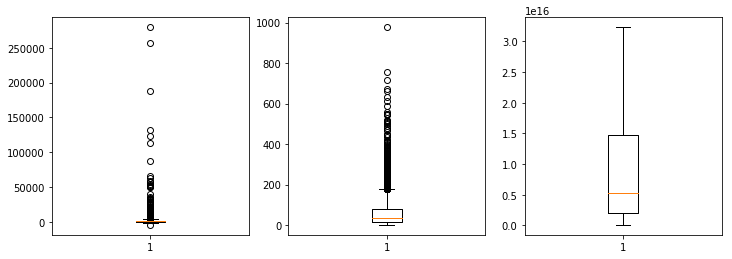

In [40]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
# outlier treatment for Amount
plt.boxplot(RFM.Amount)
Q1 = RFM.Amount.quantile(0.25)
Q3 = RFM.Amount.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.Amount >= Q1 - 1.5*IQR) & (RFM.Amount <= Q3 + 1.5*IQR)]

plt.subplot(1,3,2)
# outlier treatment for Frequency
plt.boxplot(RFM.Frequency)
Q1 = RFM.Frequency.quantile(0.25)
Q3 = RFM.Frequency.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.Frequency >= Q1 - 1.5*IQR) & (RFM.Frequency <= Q3 + 1.5*IQR)]

plt.subplot(1,3,3)
# outlier treatment for Recency
plt.boxplot(RFM.Recency)
Q1 = RFM.Recency.quantile(0.25)
Q3 = RFM.Recency.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.Recency >= Q1 - 1.5*IQR) & (RFM.Recency <= Q3 + 1.5*IQR)]

In [41]:
# standardise all parameters
RFM_norm1 = RFM.drop("CustomerID", axis=1)
RFM_norm1.Recency = RFM_norm1.Recency.dt.days

from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
RFM_norm1 = standard_scaler.fit_transform(RFM_norm1)

In [42]:
RFM_norm1 = pd.DataFrame(RFM_norm1)
RFM_norm1.columns = ['Frequency','Amount','Recency']
RFM_norm1.head()

,Frequency,Amount,Recency
0,-1.070949,-1.041614,2.136422
1,-0.375498,1.385298,-0.282050
2,0.631707,1.331702,-0.821629
3,-0.711233,-0.590055,1.982257
4,1.159290,1.045238,-0.657828


In [43]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [44]:
hopkins(RFM_norm1)

0.8899095761985518

In [45]:
# Kmeans with K=5
model_clus5 = KMeans(n_clusters = 5, max_iter=50)
model_clus5.fit(RFM_norm1)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [47]:
from sklearn.metrics import silhouette_score
sse_ = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k).fit(RFM_norm1)
    sse_.append([k, silhouette_score(RFM_norm1, kmeans.labels_)])

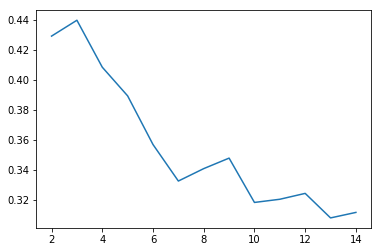

In [48]:
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1]);

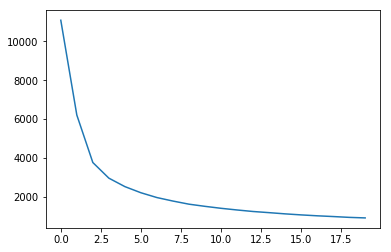

In [49]:
# sum of squared distances
ssd = []
for num_clusters in list(range(1,21)):
    model_clus = KMeans(n_clusters = num_clusters, max_iter=50)
    model_clus.fit(RFM_norm1)
    ssd.append(model_clus.inertia_)

plt.plot(ssd)